# Analysis of CRDC referral and arrest data 


This notebook contains analysis of data from the US Department of Education Civil Rights Data Collection related to arrests and law enforcement referrals of elementary school children in the US.

## Definitions

All definitions here are from the [Master List of Definitions for the 2015-2016 CRDC](https://ocrdata.ed.gov/assets/downloads/CRDC-Definitions-2015-16.pdf).

### Referral to law enforcement

> "...an action by which a student is reported to any law enforcement agency or official, including a school police unit, for an incident that occurs on school grounds, during schoolrelated events, or while taking school transportation, regardless of whether official action is taken. Citations, tickets, court referrals, and school-related arrests are considered referrals to law enforcement."

### School-Related Arrest

> "...an arrest of a student for any activity conducted on school grounds, during offcampus school activities (including while taking school transportation), or due to a referral by any school official. All school-related arrests are considered referrals to law enforcement."

### Children with Disabilities (IDEA)
> "...children with intellectual disabilities; hearing impairment, including deafness; speech or language impairment; visual impairment, including blindness; serious emotional disturbance; orthopedic impairment; autism; traumatic brain injury; developmental delay; other health impairment; specific learning disability; deaf-blindness; or multiple disabilities and who, by reason thereof, receive special education and related services under the Individuals with Disabilities Education Act according to an Individualized Education Program, Individual Family Service Plan, or service plan."

### Students With Disabilities (Section 504 Only)
> "...students with a disability, who receive related aids and services solely under Section 504 of the Rehabilitation Act of 1973, as amended, and not under the Individuals with Disabilities Education Act (IDEA). The "Section 504 Only" column in the survey items always refers to students with disabilities who receive related aids and services under Section 504 of the Rehabilitation Act of 1973, as amended, and not under IDEA."

In [1]:
import os
import re
import geopandas as gpd
import jinja2
import numpy as np
import pandas as pd
import constants


In [2]:
# papermill parameters
DIR = "."
YEAR = 2017
MAX_GRADE = 5


In [3]:
complete_df = pd.read_csv(f"{DIR}/input/crdc-referrals-arrests-cleaned.csv", dtype={0: str, 2: str, 6: str})
df = complete_df.query("year == @YEAR")
df.shape


(89161, 139)

## Overall rates

This analysis is limited to the following criteria:
1. students grades MAX_GRADE or younger
2. non-juvenile justice facilities
3. non-alternative schools

It will provide referral and arrest rates per 10,000 children

In [4]:
MULT = 10_000

assign_rates = lambda df: (
    df.assign(
        arrest_rate=lambda df: df.total_arrests / df.total_enrollment * MULT
    ).assign(referral_rate=lambda df: df.total_referrals / df.total_enrollment * MULT)
)

df = df.query("max_grade <= @MAX_GRADE").pipe(assign_rates)

complete_df = complete_df.query("max_grade <= @MAX_GRADE").pipe(assign_rates)

df.to_csv(f"{DIR}/input/2017-2018 school totals, grade {MAX_GRADE} and below.csv")


### National

Nationwide, there are about 5 referrals and 1 arrest for every 10,000 children enrolled in elementary schools.

In [5]:
national_rates = (
    df[["total_enrollment", "total_referrals", "total_arrests"]]
    .sum()
    .to_frame("United States")
    .transpose()
    .pipe(assign_rates)
)

national_rates


,total_enrollment,total_referrals,total_arrests,arrest_rate,referral_rate
United States,16762957.0,11072.0,715.0,0.426536,6.60504


### By state

The rates of referrals and arrests aren't consistent across states. Some states have rates many times the national average.

In [6]:
state_rates = (
    df.reset_index()
    .groupby("LEA_STATE")[["total_enrollment", "total_arrests", "total_referrals"]]
    .sum()
    .pipe(assign_rates)
    .sort_values("arrest_rate", ascending=False)
)

state_rates


,total_enrollment,total_arrests,total_referrals,arrest_rate,referral_rate
LEA_STATE,,,,,
NH,60629.0,25.0,126.0,4.123439,20.782134
MD,375011.0,98.0,203.0,2.613257,5.413175
VA,490704.0,106.0,1739.0,2.160162,35.438880
AZ,172861.0,33.0,321.0,1.909048,18.569834
WI,292093.0,32.0,377.0,1.095541,12.906848
PA,494242.0,42.0,971.0,0.849786,19.646246
IN,324558.0,23.0,78.0,0.708656,2.403268
HI,46363.0,3.0,12.0,0.647068,2.588271
GA,791374.0,42.0,147.0,0.530723,1.857529


### Individual schools

In [7]:
problem_schools = (
    df.query("total_arrests >= 1")
    .sort_values("total_arrests", ascending=False)
    # geocode schools using NCES school locations file
    # https://nces.ed.gov/programs/edge/geographic/schoollocations
    .pipe(
        lambda df: gpd.read_file(f"{DIR}/input/EDGE_GEOCODE_PUBLICSCH_1718")
        .to_crs("EPSG:4326")
        .merge(
            df.reset_index(), how="right", left_on=["NCESSCH"], right_on=["COMBOKEY"]
        )
    )
    # join nielsen DMAs so I know which to send to which local station
    .pipe(
        lambda df: gpd.sjoin(
            gpd.read_file(f"{DIR}/input/nielsen-dmas.geojson")[
                ["nielsen_dma", "geometry"]
            ].drop_duplicates(),
            df,
            how="right",
            predicate="contains",
        )
    )
    .drop(columns=["index_left"])
    # sjoin counties because people keep asking for them and they're not in the data
    .pipe(
        lambda df: gpd.sjoin(
            gpd.read_file(f"{DIR}/input/counties.geojson")
            .to_crs("EPSG:4326")[["NAME", "geometry"]]
            .rename(columns={"NAME": "county_name"})
            .drop_duplicates(),
            df,
            how="right",
            predicate="contains",
        )
    )[
        [
            "year",
            "SCH_NAME",
            "LEA_NAME",
            "LEA_STATE",
            "county_name",
            "nielsen_dma",
            "max_grade",
            "total_enrollment",
            "total_arrests",
            "total_referrals",
            "arrest_rate",
            "referral_rate",
        ]
    ]
)

problem_schools


,year,SCH_NAME,LEA_NAME,LEA_STATE,county_name,nielsen_dma,max_grade,total_enrollment,total_arrests,total_referrals,arrest_rate,referral_rate
0,2017,Ronald A. McNair Elementary,Montgomery County Public Schools,MD,Montgomery,"Washington, DC",5.0,845.0,13.0,14.0,153.846154,165.680473
1,2017,Christa McAuliffe School,Concord School District,NH,Merrimack,Boston,5.0,412.0,12.0,15.0,291.262136,364.077670
2,2017,BARNES EL,CORPUS CHRISTI ISD,TX,Nueces,"Corpus Christi, TX",5.0,663.0,11.0,22.0,165.912519,331.825038
3,2017,Riverside Elementary,Fond du Lac School District,WI,Fond du Lac,Green Bay-Appleton,5.0,301.0,10.0,10.0,332.225914,332.225914
4,2017,Fairfield Court Elementary,RICHMOND CITY PBLC SCHS,VA,Richmond,Richmond-Petersburg,5.0,470.0,10.0,10.0,212.765957,212.765957
...,...,...,...,...,...,...,...,...,...,...,...,...
386,2017,Loma Portal Elementary,San Diego Unified,CA,San Diego,"San Diego, CA",4.0,365.0,1.0,2.0,27.397260,54.794521
387,2017,Bay Park Elementary,San Diego Unified,CA,San Diego,"San Diego, CA",5.0,475.0,1.0,2.0,21.052632,42.105263
388,2017,Crown Point Elementary,San Diego Unified,CA,San Diego,"San Diego, CA",5.0,354.0,1.0,1.0,28.248588,28.248588
389,2017,Carson Elementary,San Diego Unified,CA,San Diego,"San Diego, CA",5.0,392.0,1.0,3.0,25.510204,76.530612


In [8]:
(
    problem_schools.rename(
        # user friendly column names for shared file
        columns={
            "year": "School Year",
            "sch_name": "School Name",
            "lea_name": "District Name",
            "lea_state_name": "State",
            "nielsen_dma": "Nielsen DMA",
            "max_grade": "Maximum grade",
            "arrests": "Total Arrests",
            "referrals": "Total Referrals",
            "arrest_rate": f"Arrest Rate (per {MULT:,} students)",
            "referral_rate": f"Referral Rate (per {MULT:,} students)",
        }
    ).to_excel(
        f"{DIR}/output/high arrest rate schools, grade {MAX_GRADE} and below.xlsx",
        index=False,
    )
)


## By race

### National

In [9]:
def get_race_from_index(df):
    df.index = df.index.map(lambda s: constants.RACE_VALUES[s.split("_")[-1]])
    return df


race_national = (
    (
        df[["total_arrests_bl", "total_arrests_wh", "total_arrests_hi"]]
        .sum()
        .to_frame("total_arrests")
        .pipe(get_race_from_index)
    )
    .join(
        df[["total_referrals_bl", "total_referrals_wh", "total_referrals_hi"]]
        .sum()
        .to_frame("total_referrals")
        .pipe(get_race_from_index)
    )
    .join(
        df[["total_enrollment_bl", "total_enrollment_wh", "total_enrollment_hi"]]
        .sum()
        .to_frame("total_enrollment")
        .pipe(get_race_from_index)
    )
    .pipe(assign_rates)
)

race_national 


,total_arrests,total_referrals,total_enrollment,arrest_rate,referral_rate
Black,349.0,3763.0,2570755.0,1.357578,14.637723
White,188.0,3785.0,7846286.0,0.239604,4.823938
Hispanic,125.0,2235.0,4546838.0,0.274916,4.915504


#### Non-white students vs white students

In [10]:
race_national_comparison = (
    race_national.transpose()
    .assign(black_vs_white=lambda df: (df.Black - df.White) / df.White)
    .assign(hispanic_vs_white=lambda df: (df.Hispanic - df.White) / df.White)[["black_vs_white", "hispanic_vs_white"]]
    .transpose()
)


### By state

In [11]:
def add_col_level(df, col):
    df = df.copy()
    df.columns = pd.MultiIndex.from_tuples((col, c) for c in df)
    return df


def group_category_state(df, category):
    return (
        df.groupby("LEA_STATE")[
            [f"total_{category}_bl", f"total_{category}_wh", f"total_{category}_hi"]
        ]
        .sum()
        .transpose()
        .pipe(get_race_from_index)
        .transpose()
        .pipe(add_col_level, category)
    )


race_state = df.query("year == 2017").pipe(
    lambda _df: group_category_state(_df, "arrests")
    .join(group_category_state(_df, "referrals"))
    .join(group_category_state(_df, "enrollment"))
)

race_state


arrests                referrals                 enrollment  \
            Black White Hispanic     Black  White Hispanic      Black   
LEA_STATE                                                               
AK            0.0   0.0      0.0       0.0    3.0      1.0      564.0   
AL            4.0   1.0      0.0      21.0   17.0      1.0    87607.0   
AR            1.0   1.0      0.0      15.0   30.0      5.0    35701.0   
AZ            2.0  13.0     11.0      23.0   57.0     95.0     9163.0   
CA            2.0   9.0     13.0     326.0  397.0    612.0    80299.0   
CO            0.0   1.0      2.0      16.0   59.0     60.0    14467.0   
CT            0.0   1.0      6.0       4.0    8.0     16.0    14991.0   
DC            0.0   0.0      0.0       7.0    0.0      1.0    23809.0   
DE            0.0   0.0      0.0      38.0   20.0     13.0    15048.0   
FL           20.0  12.0      0.0     626.0  340.0    277.0   246467.0   
GA           33.0   5.0      4.0     111.0   23.0      6.0   288776.0   
HI            0.0   0.0      1.0       0.0    1.0      1.0      644.0   
IA            6.0   1.0      0.0      37.0   60.0      9.0    12865.0   
ID            0.0   1.0      0.0       1.0   45.0      8.0      748.0   
IL            5.0   6.0      0.0      56.0   59.0     66.0    66036.0   
IN            7.0  14.0      1.0      13.0   57.0      3.0    32455.0   
KS            1.0   4.0      1.0      15.0   46.0     13.0    13399.0   
KY            0.0   2.0      0.0      32.0  110.0      2.0    29551.0   
LA            6.0   2.0      0.0      33.0   19.0      2.0    90691.0   
MA            1.0   1.0      1.0       7.0   10.0      4.0    21867.0   
MD           82.0   5.0      6.0     142.0   35.0     16.0   110592.0   
ME            0.0   0.0      0.0       0.0    9.0      0.0     1736.0   
MI            0.0   2.0      0.0      16.0  102.0      7.0    57096.0   
MN            5.0   0.0      0.0      37.0   30.0     15.0    34578.0   
MO            3.0   9.0      1.0      49.0  266.0     11.0    44706.0   
MS            0.0   0.0      0.0      32.0    9.0      1.0    83931.0   
MT            0.0   0.0      0.0       0.0    4.0      0.0      376.0   
NC            4.0   0.0      0.0     198.0  153.0     73.0   162511.0   
ND            1.0   0.0      0.0       4.0   14.0      0.0     3014.0   
NE            0.0   1.0      0.0       2.0   25.0     16.0     6995.0   
NH            3.0  20.0      0.0      10.0   99.0      6.0     1459.0   
NJ            1.0   1.0      1.0      18.0   33.0      9.0    54833.0   
NM            0.0   0.0      0.0       1.0    4.0      9.0     2516.0   
NV            2.0   4.0      2.0      22.0   56.0     23.0    23696.0   
NY            0.0   1.0      0.0      82.0   48.0     68.0   131068.0   
OH            1.0   4.0      0.0      37.0   57.0      4.0    60325.0   
OK            3.0   8.0      1.0      25.0   48.0     13.0    17608.0   
OR            0.0   0.0      0.0       0.0   24.0      2.0     4220.0   
PA           15.0  13.0     11.0     435.0  266.0    192.0    53268.0   
PR            0.0   0.0      0.0       0.0    0.0      3.0       11.0   
RI            0.0   0.0      0.0       7.0    7.0      8.0     4914.0   
SC            1.0   0.0      0.0      70.0   60.0      9.0   113523.0   
SD            0.0   0.0      0.0      12.0   22.0      2.0     2125.0   
TN           12.0   3.0      0.0      22.0   24.0      1.0    84100.0   
TX           34.0  12.0     55.0     167.0  131.0    382.0   269060.0   
UT            0.0   0.0      0.0       0.0   13.0      1.0      623.0   
VA           86.0  14.0      6.0     898.0  604.0    118.0   113108.0   
VT            0.0   0.0      0.0       2.0    3.0      1.0      578.0   
WA            0.0   0.0      0.0       7.0   31.0     12.0    15991.0   
WI            8.0  17.0      2.0      83.0  221.0     31.0    21867.0   
WV            0.0   0.0      0.0       3.0   14.0      1.0     4923.0   
WY            0.0   0.0      0.0       1.0   12.0      6.0      256.

In [12]:
(
    (
        race_state.referrals.div(race_state.enrollment)
        .multiply(MULT)
        .assign(black_vs_white=lambda df: (df.Black - df.White) / df.White)
        .assign(hispanic_vs_white=lambda df: (df.Hispanic - df.White) / df.White)[["black_vs_white", "hispanic_vs_white"]]
        .pipe(add_col_level, "referrals")
    ).join(
        race_state.arrests.div(race_state.enrollment)
        .multiply(MULT)
        .assign(black_vs_white=lambda df: (df.Black - df.White) / df.White)
        .assign(hispanic_vs_white=lambda df: (df.Hispanic - df.White) / df.White)[["black_vs_white", "hispanic_vs_white"]]
        .pipe(add_col_level, "arrests")
    ).sort_values(("referrals", "black_vs_white"), ascending=False)
)


referrals                          arrests                  
          black_vs_white hispanic_vs_white black_vs_white hispanic_vs_white
LEA_STATE                                                                  
DC                   inf               inf            NaN               NaN
VT             13.258362         10.607512            NaN               NaN
PA              9.155105          2.742917       6.165140          3.387730
SD              8.641840         -0.133735            NaN               NaN
WY              6.437174          1.755971            NaN               NaN
MN              5.889981          2.135860            inf               NaN
IA              5.757257         -0.036293      64.746288         -1.000000
MA              5.230086          0.357199       7.900123          2.392998
RI              5.130444          1.284880            NaN               NaN
MD              4.472807          0.042322      21.122472          1.736095
GA              4.073829         -0.395950       5.938804          0.852420
NY              4.020377          1.044173      -1.000000         -1.000000
IL              3.319179          1.679070       2.792136         -1.000000
WV              3.314486          2.109386            NaN               NaN
OH              3.266176         -0.110708       0.643054         -1.000000
CA              2.501012         -0.318807      -0.052555         -0.361721
WI              2.499045         -0.227555       3.384345         -0.352143
NH              2.436559         -0.379079       4.103290         -1.000000
OK              2.419078         -0.139837       1.461736         -0.603002
CT              2.190414          3.528798      -1.000000         12.586393
VA              2.146913         -0.408454      12.002167          0.297677
FL              1.928893         -0.133833       1.651288         -1.000000
WA              1.848683         -0.182657            NaN               NaN
DE              1.785985          0.353298            NaN               NaN
TX              1.745104          0.424373       5.101144          1.238788
MS              1.737105         -0.037280            NaN               NaN
CO              1.708284          0.395100      -1.000000          1.743698
NM              1.628180         -0.162244            NaN               NaN
ND              1.530666         -1.000000            inf               NaN
TN              1.440666         -0.796860       9.650178         -1.000000
KS              1.429164         -0.238594       0.862359         -0.326448
AZ              1.389787          0.063728      -0.088844         -0.459953
NC              1.293364          0.122838            inf               NaN
NJ              0.952268         -0.456843       2.579159          0.991577
LA              0.922053         -0.477371       2.319910         -1.000000
ID              0.843523         -0.394199      -1.000000         -1.000000
KY              0.796517         -0.838317      -1.000000         -1.000000
AL              0.699409         -0.687245       4.502848         -1.000000
SC              0.691303         -0.275158            inf               NaN
IN              0.574229         -0.696781       2.451194         -0.588488
AR              0.357385         -0.350097       1.714770         -1.000000
MO             -0.083587         -0.549931       0.658271          0.209276
MI             -0.092687         -0.413270      -1.000000         -1.000000
NV             -0.130462         -0.740858       0.106685         -0.684523
NE             -0.301044          1.081064      -1.000000         -1.000000
HI             -1.000000         -0.442283            NaN               inf
MT             -1.000000         -1.000000            NaN               NaN
UT             -1.000000         -0.615217            NaN               NaN
OR             -1.000000         -0.798083            NaN               NaN
ME             -1.000000         -1.000000            NaN      

## By disability status

### National

In [13]:
def group_category_national(df, category, name):
    return (
        df[
            [
                f"total_enrollment_{category}",
                f"total_referrals_{category}",
                f"total_arrests_{category}",
            ]
        ]
        .sum()
        .to_frame("United States")
        .transpose()
        .rename(columns=lambda col: col.replace(f"_{category}", ""))
        .pipe(assign_rates)
        .pipe(add_col_level, name)
    )


dis_national = (
    group_category_national(df, "idea", "IDEA")
    .join(group_category_national(df, "nondis", "Without Disabilities"))
    .unstack()
    .droplevel(2)
    .to_frame()
    .reset_index()
    .pivot_table(index="level_0", columns="level_1")
    .droplevel(0, axis=1)[
        [
            "total_arrests",
            "total_referrals",
            "total_enrollment",
            "arrest_rate",
            "referral_rate",
        ]
    ]
)

dis_national.index.name = None
dis_national.columns.name = None

dis_national


,total_arrests,total_referrals,total_enrollment,arrest_rate,referral_rate
IDEA,246.0,3861.0,2195721.0,1.120361,17.584201
Without Disabilities,469.0,7211.0,16762957.0,0.279784,4.301747


### By state

In [14]:
def group_category_state(df, category, name):
    return (
        df.groupby("LEA_STATE")[
            [
                f"total_enrollment_{category}",
                f"total_referrals_{category}",
                f"total_arrests_{category}",
            ]
        ]
        .sum()
        .rename(columns=lambda col: col.replace(f"_{category}", ""))
        .pipe(assign_rates)
        .pipe(add_col_level, name)
    )

dis_state = group_category_state(df, "idea", "IDEA").join(group_category_state(df, "nondis", "Without Disabilities"))
dis_state


IDEA                                            \
          total_enrollment total_referrals total_arrests arrest_rate   
LEA_STATE                                                              
AK                  3818.0            10.0           0.0    0.000000   
AL                 33732.0            12.0           2.0    0.592909   
AR                 20529.0            14.0           1.0    0.487116   
AZ                 21407.0            64.0          15.0    7.007054   
CA                162260.0           354.0           4.0    0.246518   
CO                 35174.0            47.0           2.0    0.568602   
CT                 22960.0            22.0           4.0    1.742160   
DC                  4486.0             3.0           0.0    0.000000   
DE                  7491.0            28.0           0.0    0.000000   
FL                157212.0           535.0           7.0    0.445259   
GA                 97251.0            44.0          10.0    1.028267   
HI                  4348.0             6.0           3.0    6.899724   
IA                 22663.0            60.0           6.0    2.647487   
ID                  9368.0            20.0           0.0    0.000000   
IL                 75969.0            92.0           4.0    0.526531   
IN                 48663.0            36.0          10.0    2.054949   
KS                 25859.0            41.0           4.0    1.546850   
KY                 46578.0            68.0           1.0    0.214694   
LA                 27265.0            14.0           3.0    1.100312   
MA                 52851.0            11.0           0.0    0.000000   
MD                 42267.0            74.0          24.0    5.678189   
ME                  9233.0             6.0           0.0    0.000000   
MI                 57366.0            64.0           1.0    0.174319   
MN                 42596.0            53.0           2.0    0.469528   
MO                 43833.0           116.0           4.0    0.912554   
MS                 22595.0             8.0           0.0    0.000000   
MT                  5314.0             4.0           0.0    0.000000   
NC                 77457.0           134.0           3.0    0.387312   
ND                  5267.0            16.0           1.0    1.898614   
NE                 15072.0            21.0           0.0    0.000000   
NH                  9913.0            33.0           0.0    0.000000   
NJ                 64399.0            24.0           1.0    0.155282   
NM                 16994.0             5.0           0.0    0.000000   
NV                 25114.0            37.0           2.0    0.796369   
NY                138228.0           117.0           1.0    0.072344   
OH                 74172.0            32.0           2.0    0.269644   
OK                 35113.0            41.0           3.0    0.854384   
OR                 24840.0            11.0           0.0    0.000000   
PA                 74068.0           333.0          22.0    2.970244   
PR                 30807.0             2.0           0.0    0.000000   
RI                  8951.0             7.0           0.0    0.000000   
SC                 46809.0            66.0           0.0    0.000000   
SD                  8351.0            28.0           1.0    1.197461   
TN                 48958.0            17.0           8.0    1.634054   
TX                195849.0           243.0          45.0    2.297689   
UT                  8985.0             5.0           0.0    0.000000   
VA                 63010.0           633.0          32.0    5.078559   
VT                  2230.0             6.0           0.0    0.000000   
WA                 50375.0            35.0           0.0    0.000000   
WI                 42702.0           193.0          18.0    4.215259   
WV                 20467.0             5.0           0.0    0.000000   
WY                  4502.0            11.0           0.0    0.000000   

                        Without Disabilities                 

## Trends

<Axes: xlabel='year'>

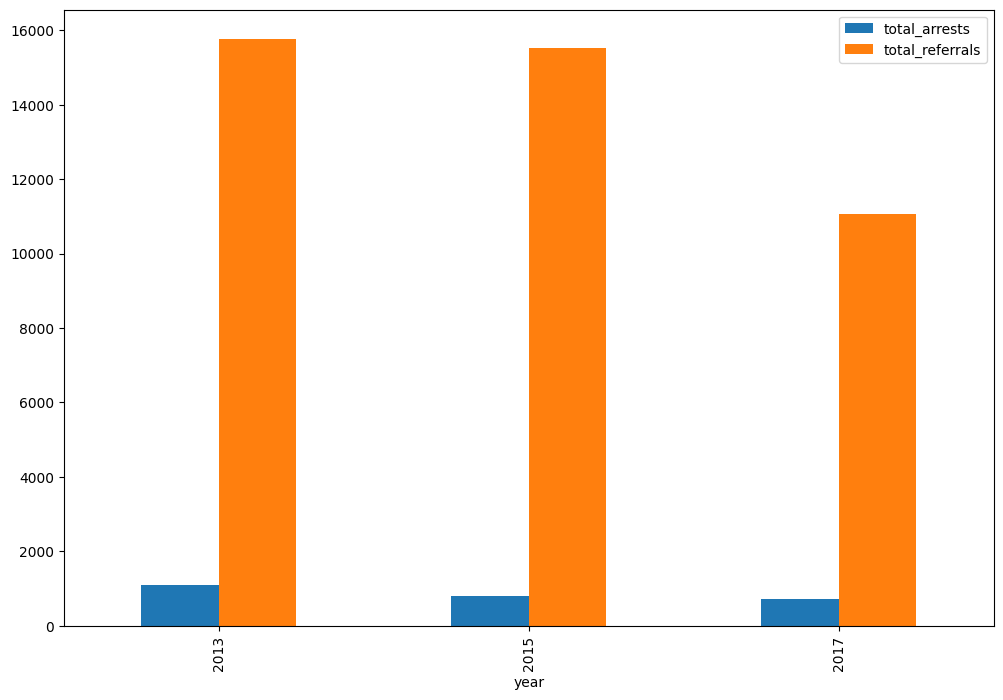

In [15]:
complete_df.groupby("year")[["total_arrests", "total_referrals"]].sum().plot(kind="bar", figsize=(12, 8))

<Axes: title={'center': 'Arrests per 1,000 children'}, xlabel='year'>

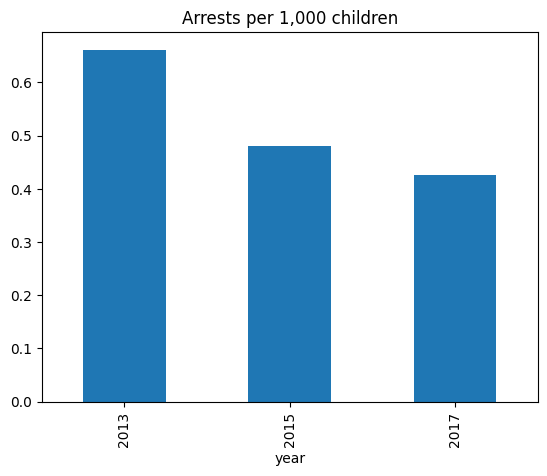

In [16]:
(
    complete_df
    .groupby("year")[["total_arrests", "total_enrollment"]]
    .sum()
    .assign(arrest_rate=lambda df: df
    .total_arrests / df
    .total_enrollment * MULT)
    .arrest_rate
    .plot(kind="bar", title="Arrests per 1,000 children")
)

In [17]:
state_trends = pd.crosstab(
    index=complete_df.LEA_STATE,
    columns=complete_df.year,
    values=complete_df.total_arrests,
    aggfunc="sum",
)

state_trends


year,2013,2015,2017
LEA_STATE,,,
AK,0.0,0.0,0.0
AL,2.0,26.0,5.0
AR,14.0,4.0,3.0
AZ,18.0,14.0,33.0
CA,42.0,10.0,28.0
CO,0.0,2.0,5.0
CT,12.0,4.0,8.0
DC,2.0,0.0,0.0
DE,0.0,2.0,0.0


## Output

### Generate reports for local stations


In [18]:
MARKETS = {
    "New York": {"state": "NY"},
    "Los Angeles": {"state": "CA"},
    "Chicago": {"state": "IL"},
    "DFW": {"state": "TX"},
    "Philadelphia": {"state": "PA"},
    "Pittsburgh": {"state": "PA"},
    "Boston": {"state": "MA"},
    "Miami": {"state": "FL"},
    "Sacramento": {"state": "CA"},
    "Bay Area": {"state": "CA"},
    "Detroit": {"state": "MI"},
    "Colorado": {"state": "CO"},
    "Baltimore": {"state": "MD"},
    "Minnesota": {"state": "MN"},
}

env = jinja2.Environment(
    loader=jinja2.FileSystemLoader(f"{DIR}/hand/"), undefined=jinja2.StrictUndefined
)
template = env.get_template("report_template.md")
# overall national rate series
nrs = national_rates.iloc[0]

path = f"{DIR}/output/reports"
if not os.path.exists(path):
    os.makedirs(path)

for market_name, market_info in MARKETS.items():
    content = template.render(
        market_name=market_name,
        state=market_info["state"],
        national_total_arrests=nrs.total_arrests,
        national_total_referrals=nrs.total_referrals,
        pct_arrested_1_in_x=round(nrs.total_referrals / nrs.total_arrests),
        arrest_rate_black_vs_white=round(
            race_national.query("index == 'Black'").iloc[0].arrest_rate
            / race_national.query("index == 'White'").iloc[0].arrest_rate,
            1,
        ),
        arrest_rate_idea_vs_nondis=round(
            dis_national.query("index == 'IDEA'").iloc[0].arrest_rate
            / dis_national.query("index == 'Without Disabilities'").iloc[0].arrest_rate,
            1,
        ),
        state_total_arrests=state_rates.query("index == @market_info['state']")
        .iloc[0]
        .total_arrests,
        state_total_referrals=state_rates.query("index == @market_info['state']")
        .iloc[0]
        .total_referrals,
        state_total_arrests_white=race_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .arrests.White,
        state_total_arrests_black=race_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .arrests.Black,
        state_total_arrests_hispanic=race_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .arrests.Hispanic,
        state_total_referrals_white=race_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .referrals.White,
        state_total_referrals_black=race_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .referrals.Black,
        state_total_referrals_hispanic=race_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .referrals.Hispanic,
        state_total_arrests_idea=dis_state.query("index == @market_info['state']")
        .iloc[0]
        .IDEA.total_arrests,
        state_total_referrals_idea=dis_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .IDEA.total_referrals,
        state_total_arrests_nondis=dis_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]["Without Disabilities"]
        .total_arrests,
        state_total_referrals_nondis=dis_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]["Without Disabilities"]
        .total_referrals,
    )

    with open(
        f"{DIR}/output/reports/crdc-data-g{MAX_GRADE}-{market_name.lower().replace(' ', '-')}-year-ending-{YEAR}.md",
        "w",
        encoding="utf-8",
    ) as f:
        f.write(content)


### Write data files to excel

In [19]:
with pd.ExcelWriter(
    f"{DIR}/output/crdc-le-analysis-g{MAX_GRADE}-and-below-year-ending-{YEAR}.xlsx"
) as writer:
    national_rates.to_excel(writer, sheet_name="Overall - National")
    state_rates.to_excel(writer, sheet_name="Overall - By State")
    race_national.to_excel(writer, sheet_name="Race - National")
    race_state.to_excel(writer, sheet_name="Race - By State")
    dis_national.to_excel(writer, sheet_name="Disability - National")
    dis_state.to_excel(writer, sheet_name="Disability - By State")
    problem_schools.to_excel(writer, sheet_name="Individual Schools With Arrests")
